In [1]:
%pip install yfinance keras

You should consider upgrading via the '/Users/vitto/university/Vienna/master-thesis/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping


/Users/vitto/university/Vienna/master-thesis/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
vix_ticker = "^VIX"

vix_data = yf.download(
    vix_ticker,
    start="2004-01-01",
    end=None,
    interval="1d",
    progress=False
)

vix_data.head()

YF.download() has changed argument auto_adjust default to True


Price,Close,High,Low,Open,Volume
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,
2004-01-02,18.219999,18.68,17.540001,17.959999,0
2004-01-05,17.490000,18.49,17.440001,18.450001,0
2004-01-06,16.730000,17.67,16.190001,17.660000,0
2004-01-07,15.500000,16.75,15.500000,16.719999,0
2004-01-08,15.610000,15.68,15.320000,15.420000,0


In [4]:
n_steps_past = 20  # number of days used to predict future prices
n_steps_future = 5  # number of days to predict

In [5]:
prices = vix_data[['Close']].ffill()

split_date = pd.to_datetime("2024-04-30")

train_data = prices[prices.index <= split_date]
test_data = prices[prices.index > split_date]

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)

scaled_prices = np.concatenate([scaled_train, scaled_test])

In [6]:

# pair [x...xn] features to [y...ym] targets
def create_sequences(data, input_steps=10, output_steps=5):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[i:i+input_steps])
        y.append(data[i+input_steps:i+input_steps+output_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_prices, n_steps_past, n_steps_future)

X = X.reshape(-1, n_steps_past, 1)
y = y.reshape(-1, n_steps_future) 


In [7]:
input_end_indices = [i + (n_steps_past - 1) for i in range(len(X))]
input_end_dates = prices.index[input_end_indices]

train_mask = input_end_dates <= split_date

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[~train_mask], y[~train_mask]

In [8]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(n_steps_past, 1)))
# model.add(Dropout(0.1))
model.add(LSTM(32, return_sequences=False))
# model.add(Dropout(0.25))
model.add(Dense(n_steps_future))

model.compile(optimizer='adam', loss='mse')

model.summary()

/Users/vitto/university/Vienna/master-thesis/venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,477 (115.14 KB)

 Trainable params: 29,477 (115.14 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1212 - val_loss: 0.0204
Epoch 2/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0108 - val_loss: 0.0214
Epoch 3/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0094 - val_loss: 0.0203
Epoch 4/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0086 - val_loss: 0.0184
Epoch 5/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0086 - val_loss: 0.0180
Epoch 6/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0084 - val_loss: 0.0165
Epoch 7/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0077 - val_loss: 0.0161
Epoch 8/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0070 - val_loss: 0.0159
Epoch 9/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0066 - val_loss: 0.0153
Epoch 10/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0069 - val_loss: 0.0149
Epoch 11/1000
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0062 - val_loss: 0.0143
Epoch 12/1000
160/160 ━━━━━━━━

In [10]:
test_loss = model.evaluate(X_test, y_test, verbose=0)
test_loss

0.012073109857738018

In [11]:
y_pred_scaled = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).reshape(-1, n_steps_future)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1, n_steps_future)

def calculate_metrics(true, pred):
    true_flat = true.flatten()
    pred_flat = pred.flatten()
    
    mse = np.mean((true_flat - pred_flat) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(true_flat - pred_flat))
    mape = np.mean(np.abs((true_flat - pred_flat) / true_flat)) * 100
    
    return mse, rmse, mae, mape

mse, rmse, mae, mape = calculate_metrics(y_true, y_pred)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
MSE: 16.33
RMSE: 4.04
MAE: 2.33
MAPE: 11.43%


Text(0, 0.5, 'True')

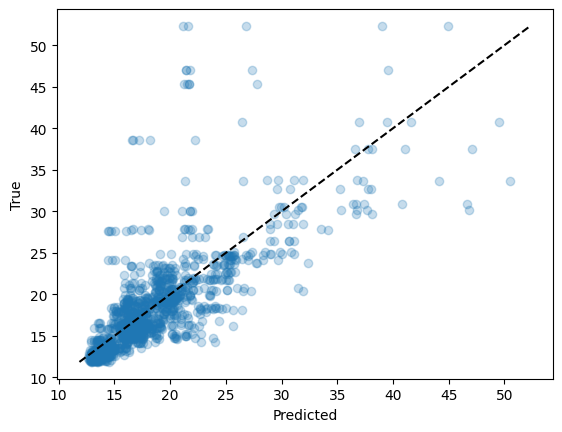

In [12]:
min_ = min(np.min(y_pred), np.min(y_true))
max_ = max(np.max(y_pred), np.max(y_true))
plt.scatter(y_pred, y_true, alpha=0.25)
plt.plot([min_,max_],[min_,max_],"k--")
plt.xlabel("Predicted")
plt.ylabel("True")

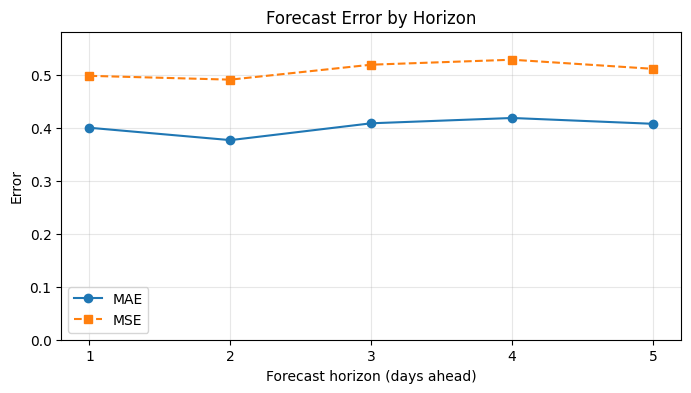

In [ ]:
def plot_error_horizion():
    n_samples  = 100
    y_true = np.cumsum(np.random.randn(n_samples, n_steps_future), axis=1) + 20
    y_pred = y_true + np.random.randn(n_samples, n_steps_future) * 0.5

    horizons = np.arange(1, n_steps_future + 1)
    maes = [mean_absolute_error(y_true[:, h-1], y_pred[:, h-1]) for h in horizons]
    mses = [np.sqrt(mean_squared_error(y_true[:, h-1], y_pred[:, h-1])) for h in horizons]

    plt.figure(figsize=(8, 4))
    plt.plot(horizons, maes,  marker='o', label='MAE')
    plt.plot(horizons, mses, marker='s', linestyle='--', label='MSE')
    plt.xticks(horizons)
    plt.ylim(0, max(mses)*1.1)
    plt.xlabel('Forecast horizon (days ahead)')
    plt.ylabel('Error')
    plt.title('Forecast Error by Horizon')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_error_horizion()

### Plot with same y axis

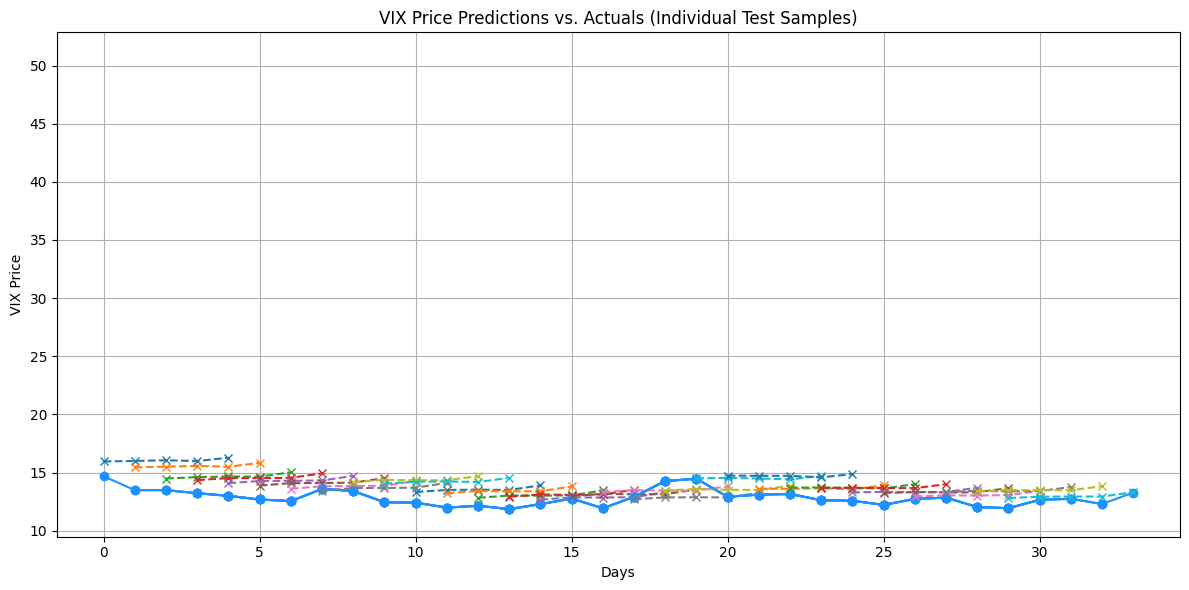

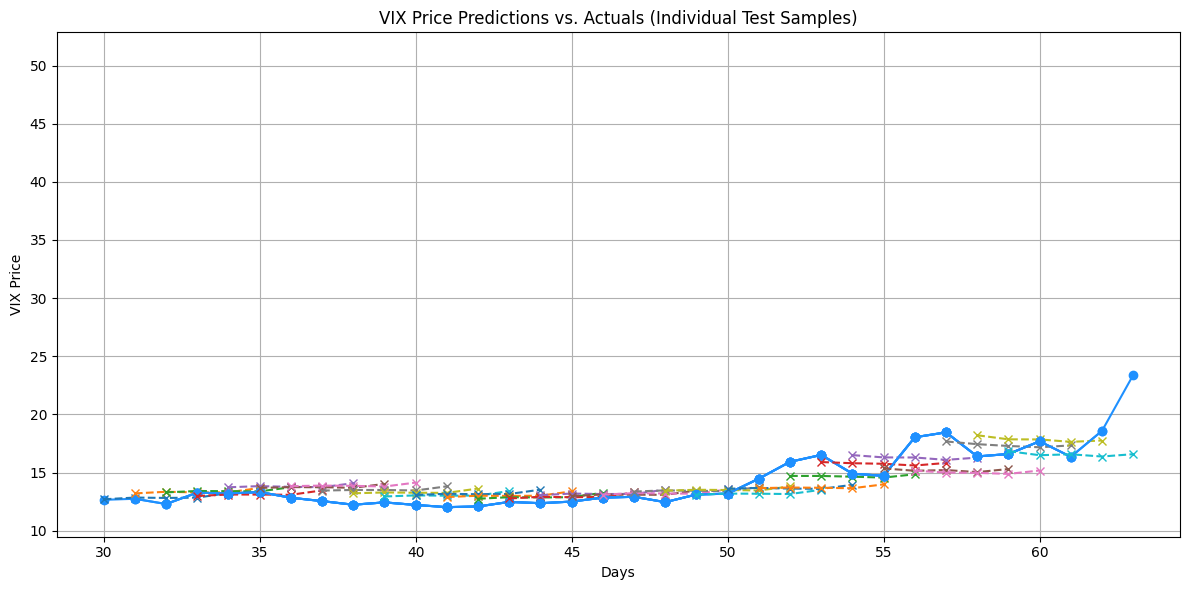

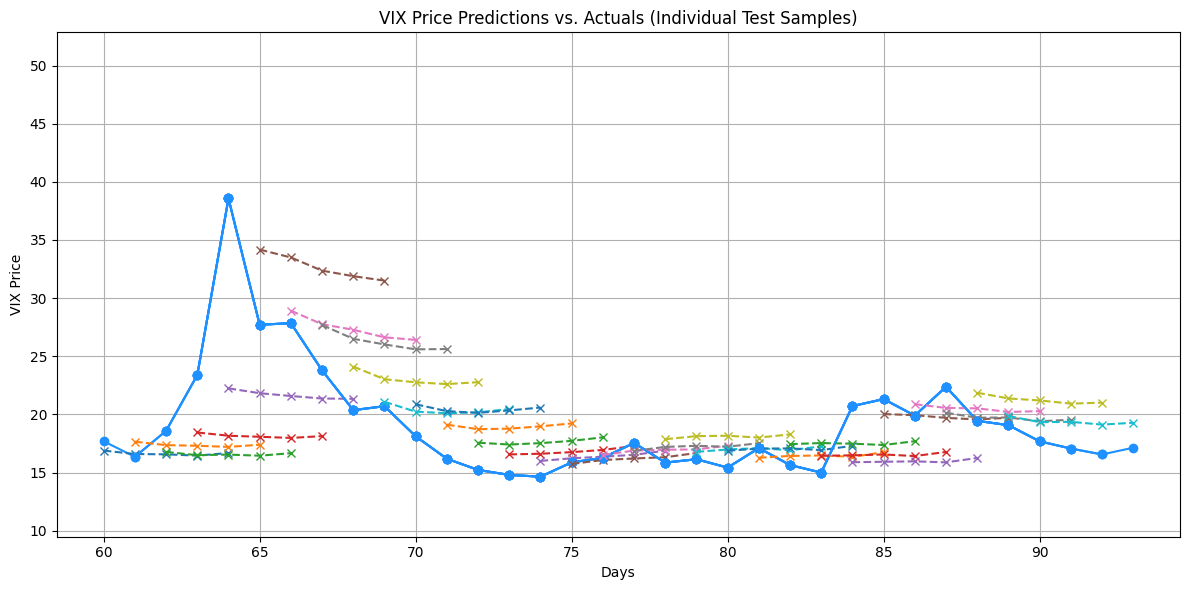

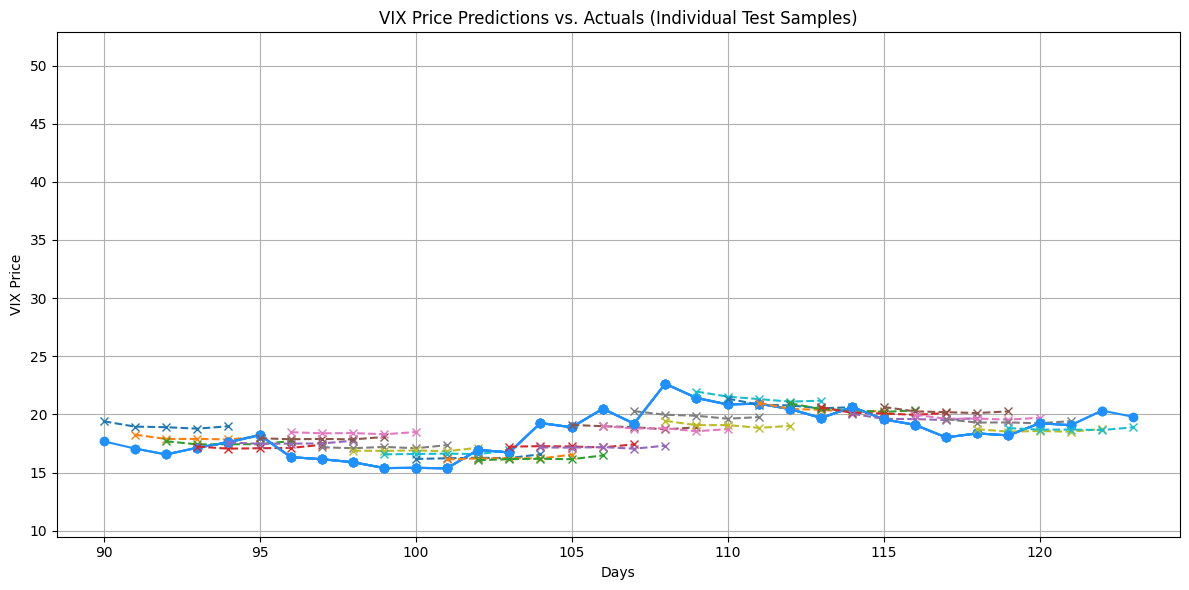

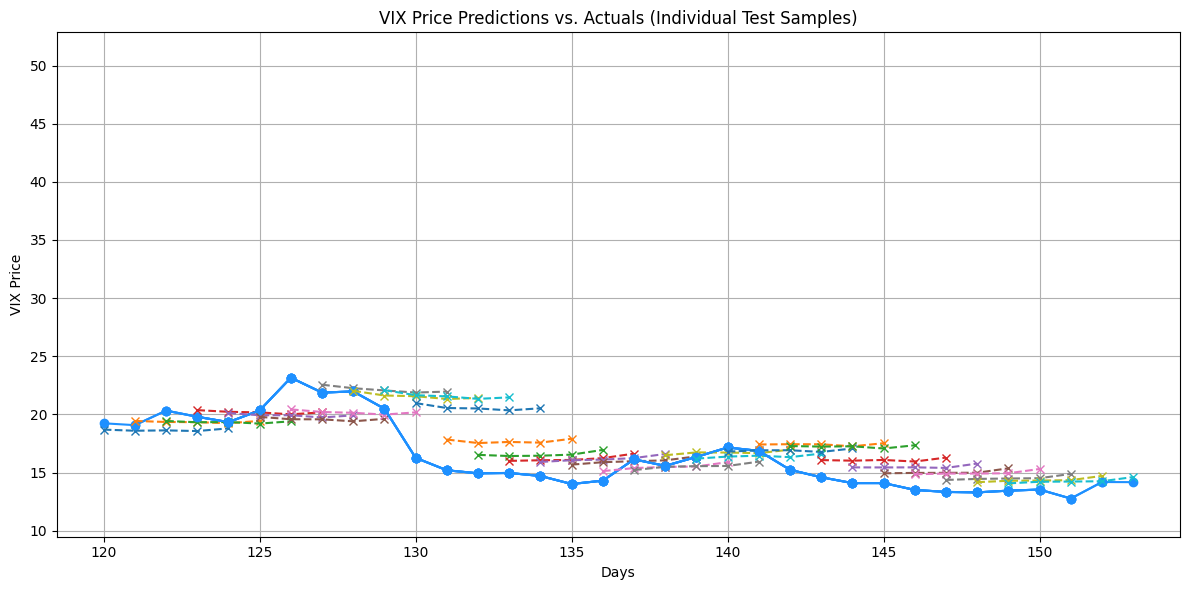

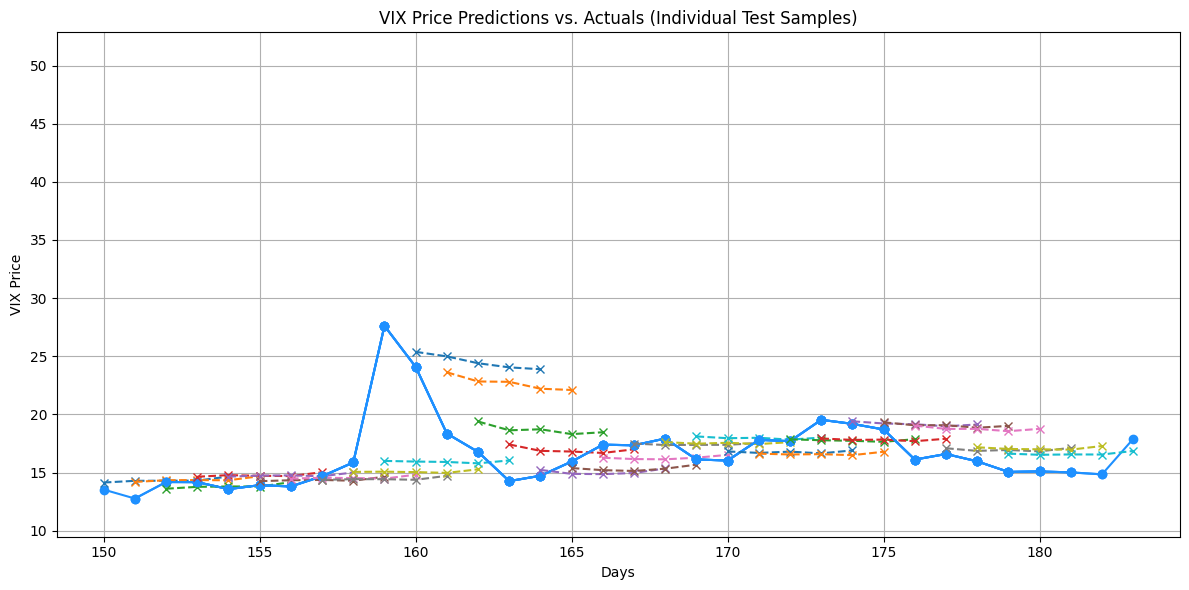

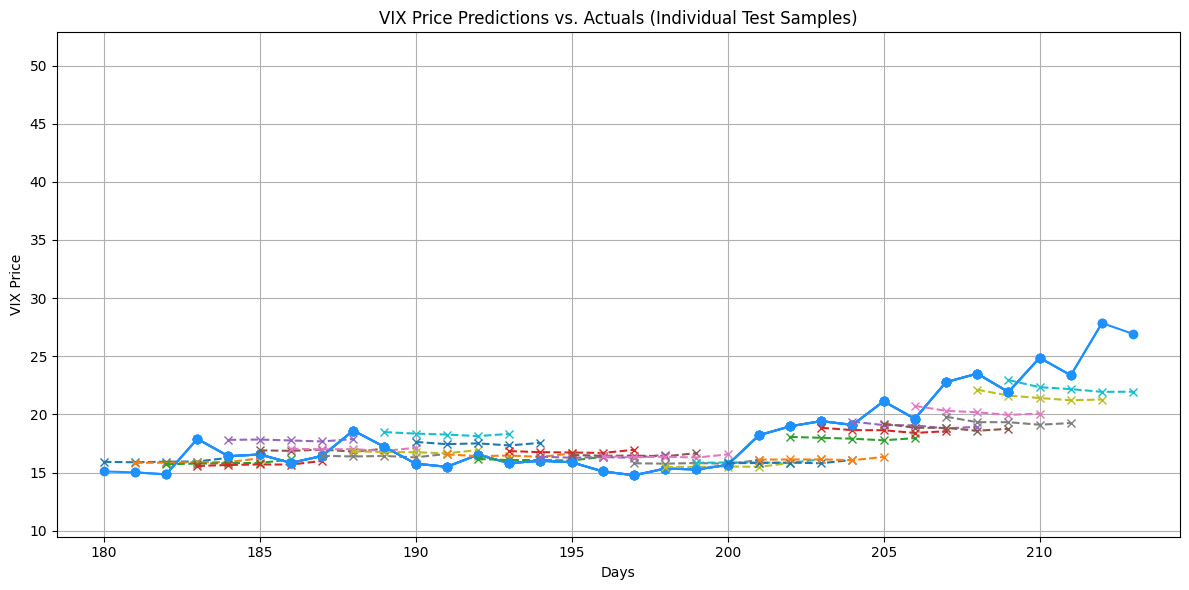

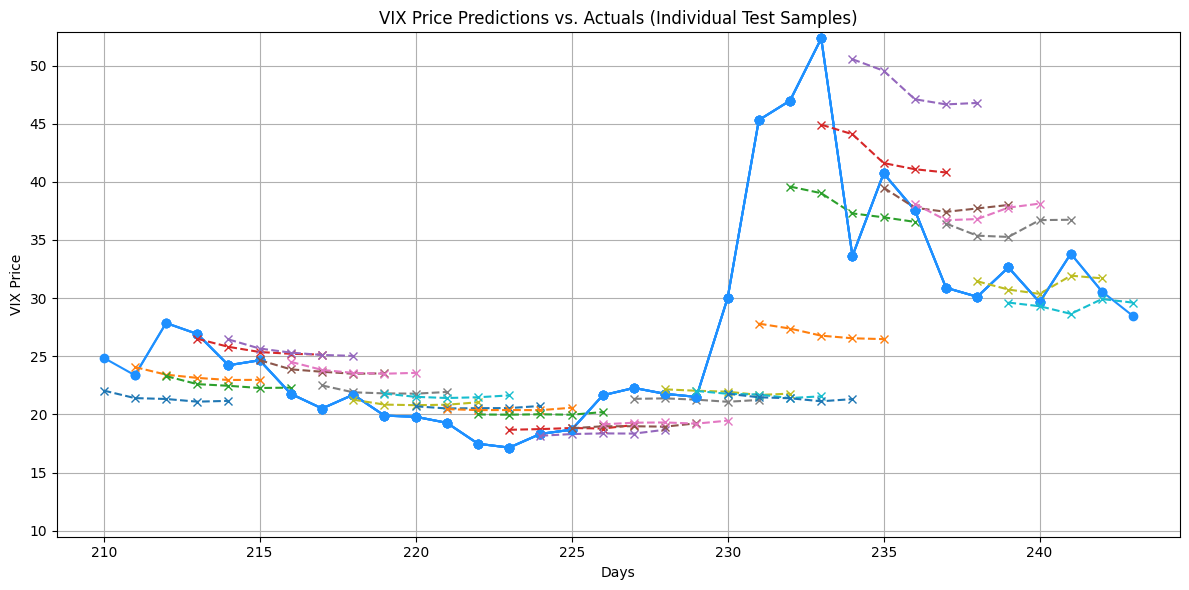

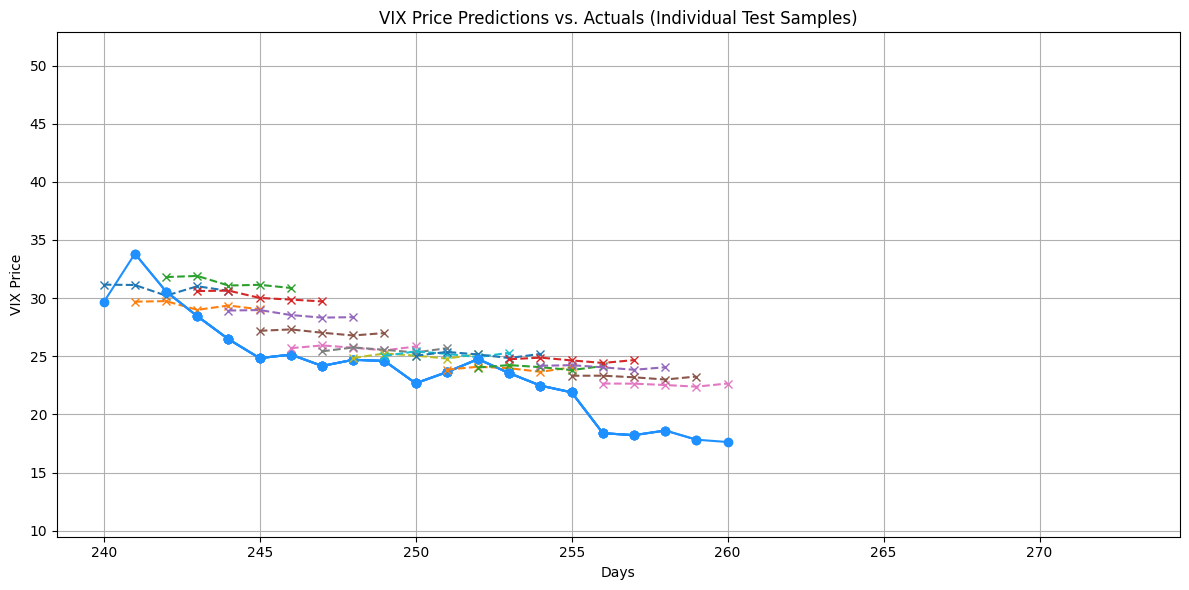

In [28]:
global_max = max(np.nanmax(y_true), np.nanmax(y_pred))
global_min = min(np.nanmin(y_true), np.nanmin(y_pred))

ylim_upper = global_max * 1.01
ylim_lower = global_min * 0.8

days_plot = 30
for start_day in range(0, len(y_pred), days_plot):
    end_day = min(start_day + days_plot, len(y_pred))
    n_samples = end_day - start_day

    fig, ax = plt.subplots(figsize=(12, 6))
    for i in range(n_samples):
        x = range(start_day + i, start_day + i + n_steps_future)
        ax.plot(x, y_true[start_day + i], marker='o', linewidth=1.5, label=f"Actual (Sample {i+1})", color="dodgerblue")
        ax.plot(x, y_pred[start_day + i], linestyle='--', marker='x', label=f"Predicted (Sample {i+1})")

    ax.set_ylim(ylim_lower, ylim_upper)
    ax.set_xlim((start_day - 1.5, start_day + days_plot + 4.5))

    ax.set_title("VIX Price Predictions vs. Actuals (Individual Test Samples)")
    ax.set_xlabel("Days")
    ax.set_ylabel("VIX Price")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

### Plot with different y axis for each chart

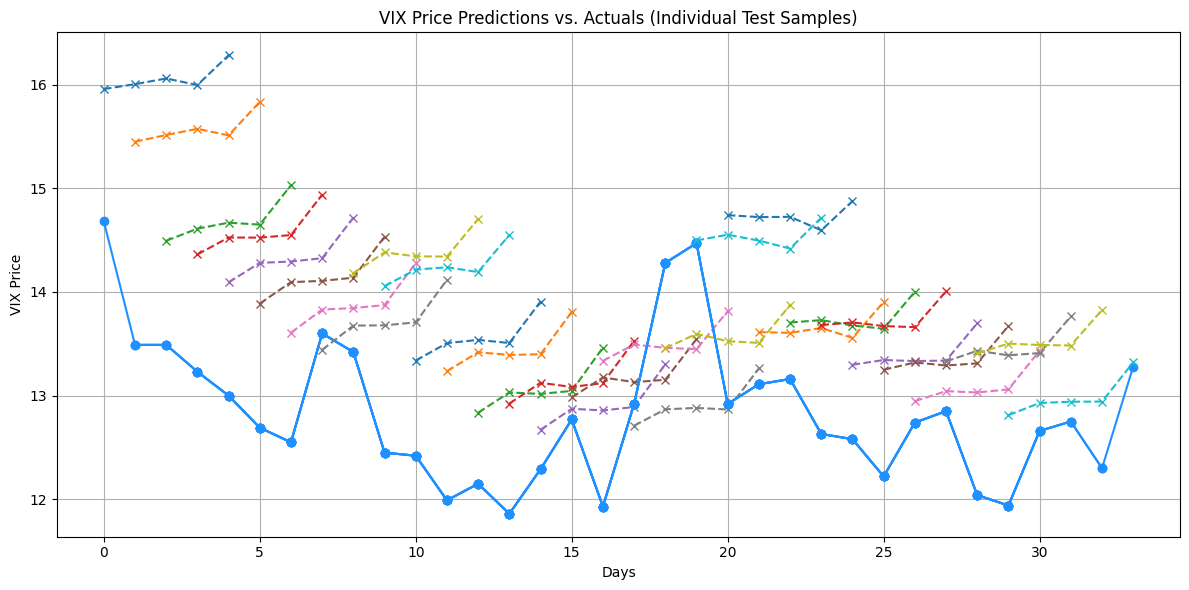

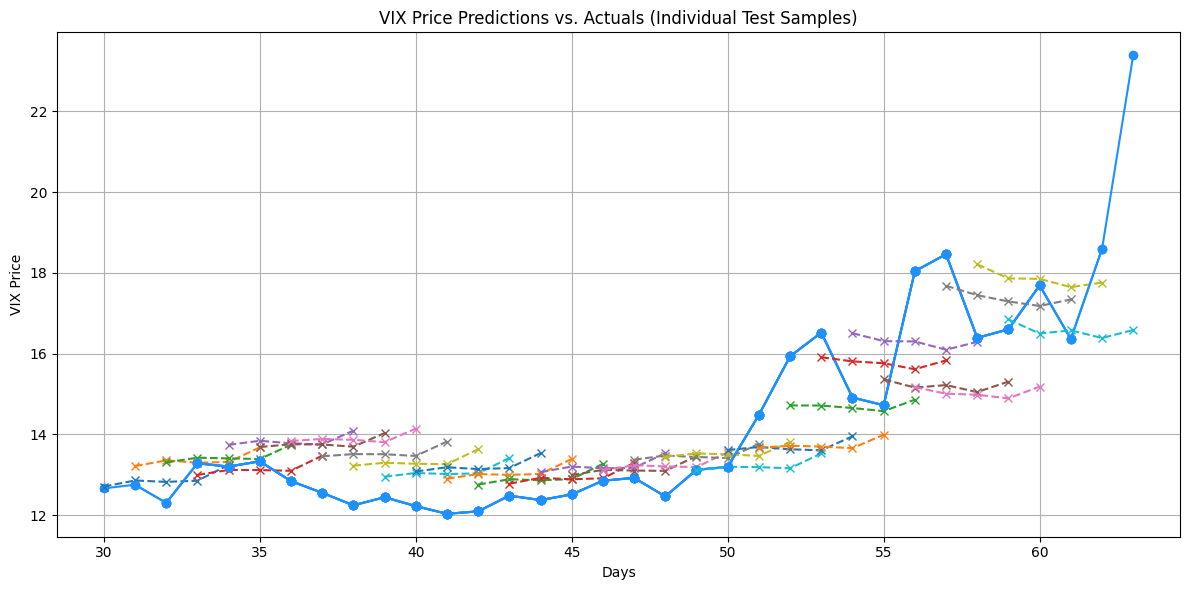

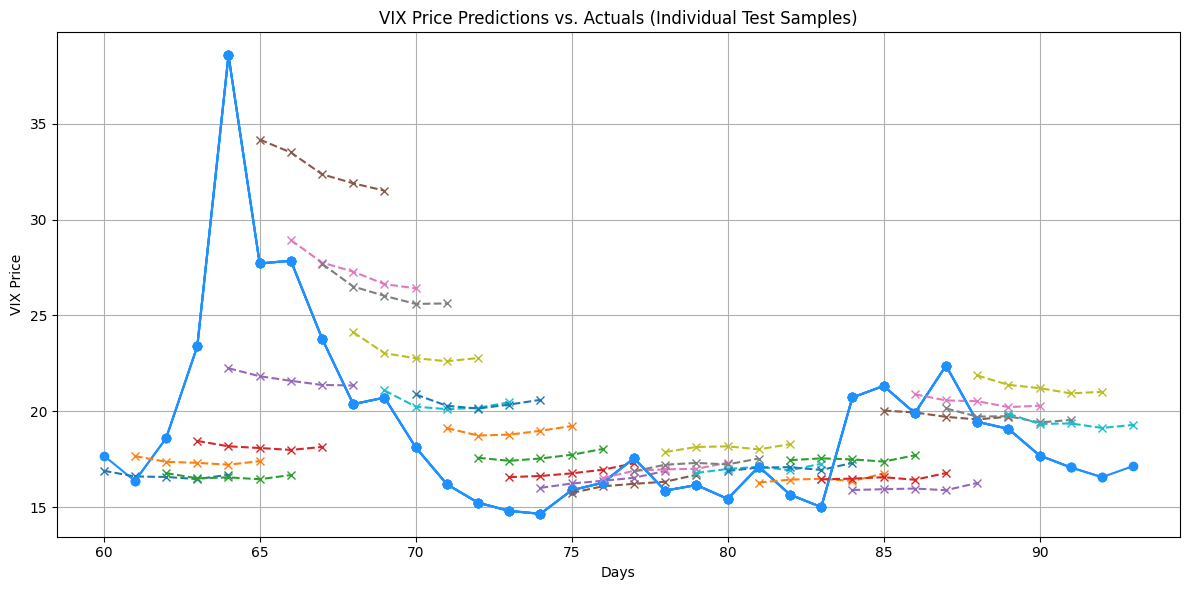

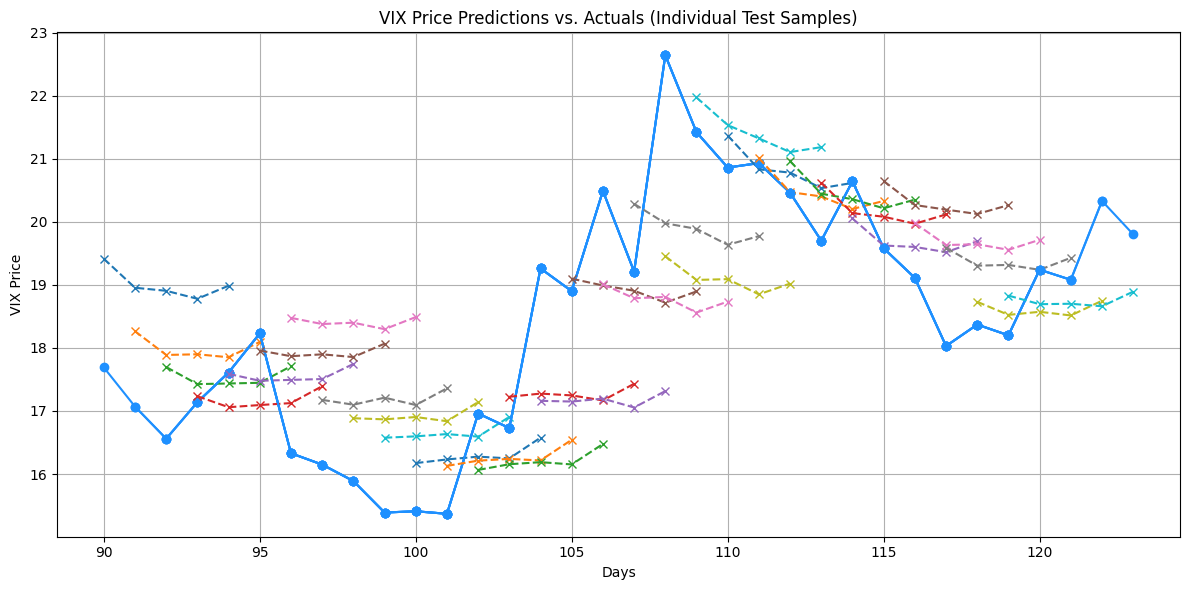

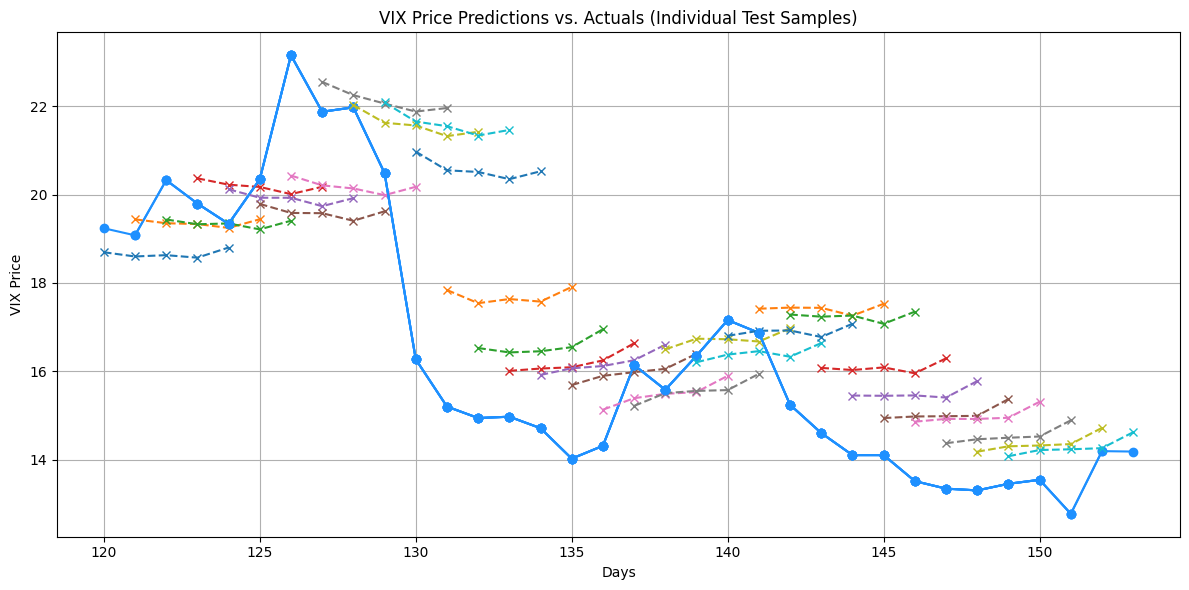

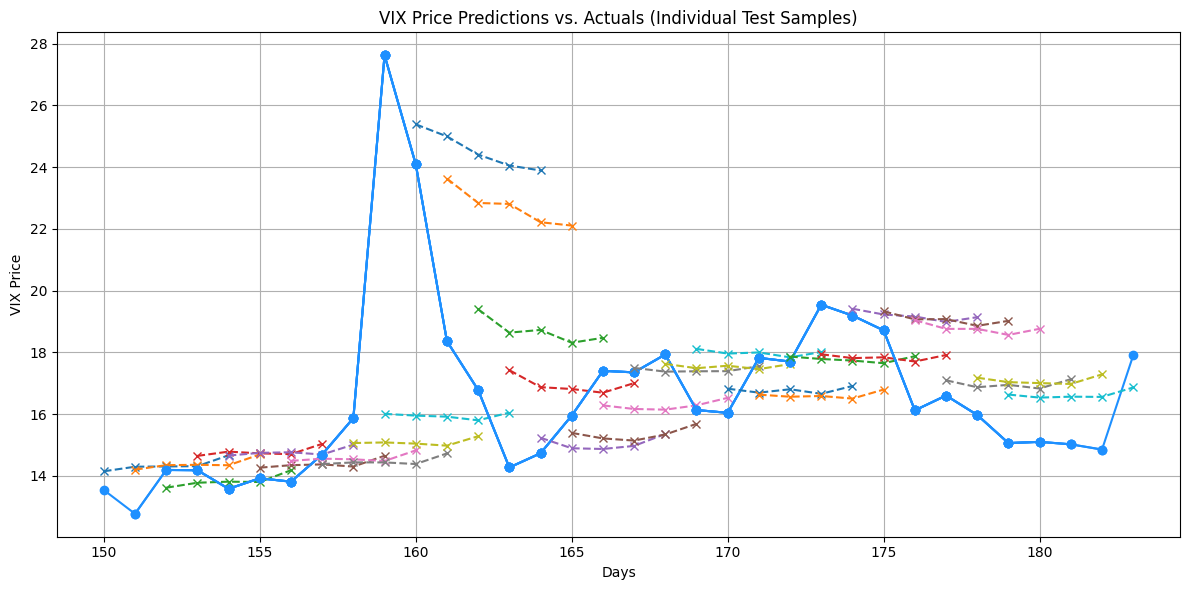

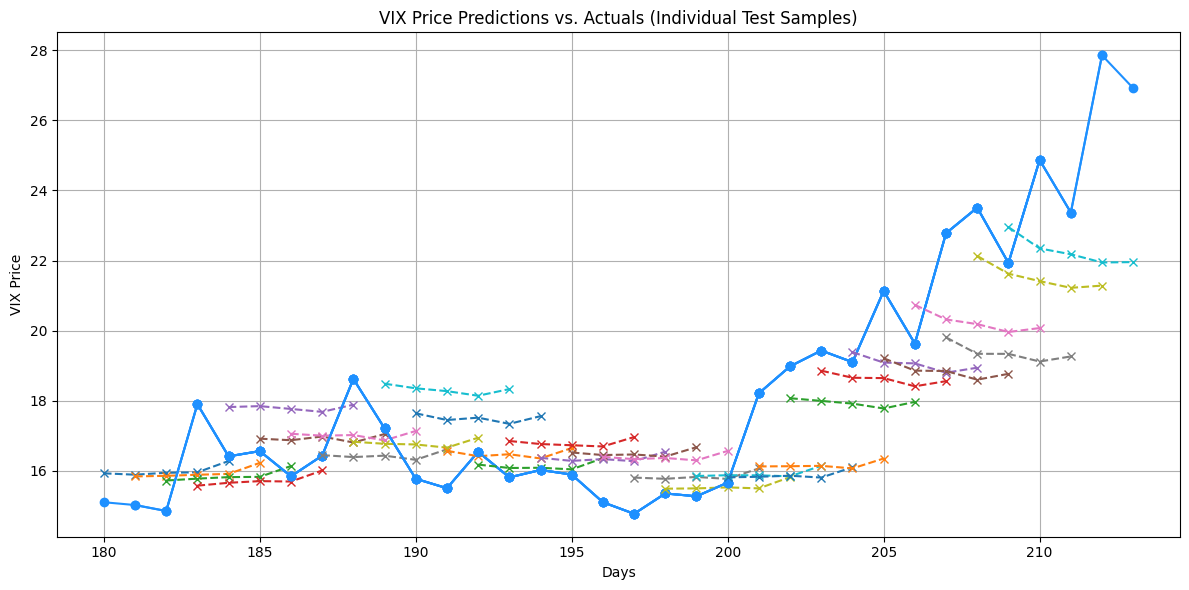

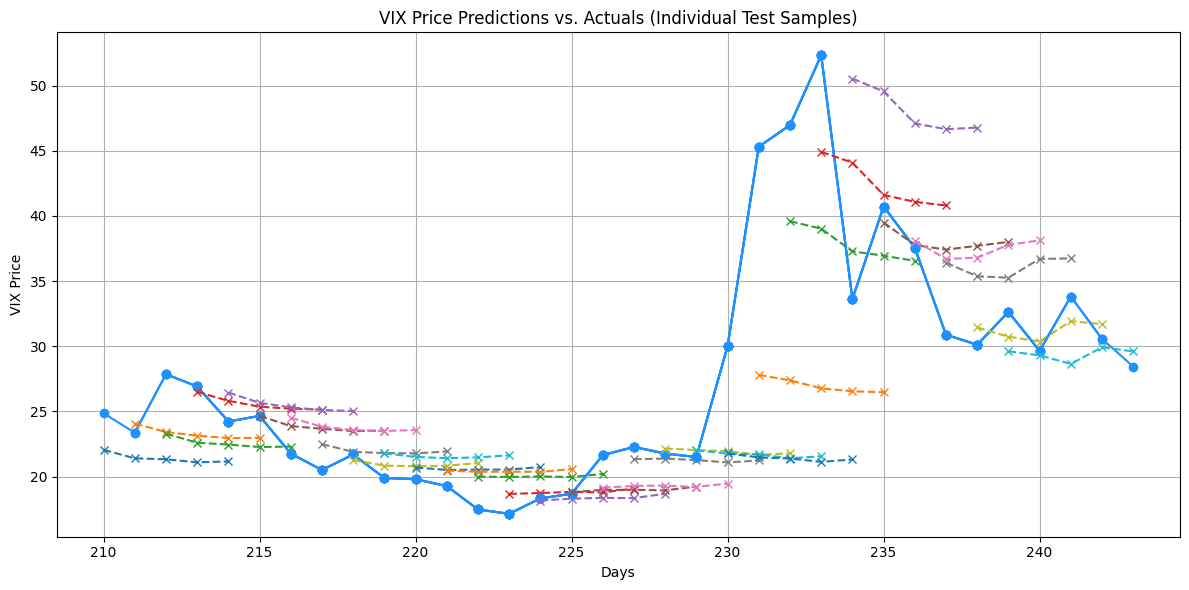

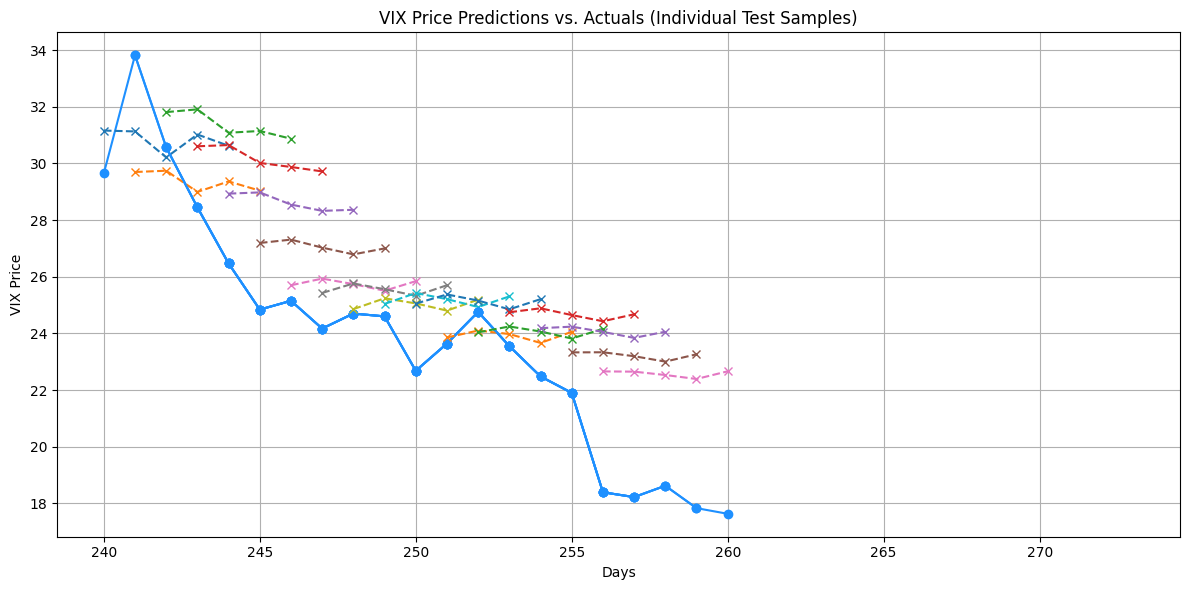

In [29]:
import matplotlib.pyplot as plt

test_input_end_dates = input_end_dates[~train_mask]

days_plot = 30
for start_day in range(0, len(y_pred), days_plot):
    end_day = min(start_day + days_plot, len(y_pred))
    n_samples = end_day - start_day

    fig, ax = plt.subplots(figsize=(12, 6))
    for i in range(n_samples):
        x = range(start_day + i, start_day + i + n_steps_future)
        ax.plot(x, y_true[start_day + i], marker='o', linewidth=1.5, label=f"Actual (Sample {i+1})", color="dodgerblue")
        ax.plot(x, y_pred[start_day + i], linestyle='--', marker='x', label=f"Predicted (Sample {i+1})")

    ax.set_xlim((start_day - 1.5, start_day + days_plot + 4.5))

    ax.set_title("VIX Price Predictions vs. Actuals (Individual Test Samples)")
    ax.set_xlabel("Days")
    ax.set_ylabel("VIX Price")
    ax.grid(True)
    plt.tight_layout()
    plt.show()